In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as scp

In [ ]:
#Deepsig was used to make these predictions
#https://academic.oup.com/bioinformatics/article/34/10/1690/4769493
sig_pep_df = pd.read_csv(
    '../../inputs/deepsig_results.csv',
    sep = '\t',
    header = None,
    names = ['gene','origin','feature','start','end','score','dot1','dot2','evidence'],
)
sig_pep_df.head()

In [3]:
sig_pep_df['gene'].duplicated().any()

True

In [4]:
sig_pep_df.groupby('gene').filter(lambda g: len(g) > 1)

,gene,origin,feature,start,end,score,dot1,dot2,evidence
16,Sulf1,DeepSig,Signal peptide,1,27,0.97,.,.,evidence=ECO:0000256
17,Sulf1,DeepSig,Chain,28,870,.,.,.,evidence=ECO:0000256
29,Pi15,DeepSig,Signal peptide,1,32,0.82,.,.,evidence=ECO:0000256
30,Pi15,DeepSig,Chain,33,269,.,.,.,evidence=ECO:0000256
31,Crispld1,DeepSig,Signal peptide,1,23,0.87,.,.,evidence=ECO:0000256
...,...,...,...,...,...,...,...,...,...
11386,Glra2,DeepSig,Chain,19,452,.,.,.,evidence=ECO:0000256
11389,Egfl6,DeepSig,Signal peptide,1,18,0.94,.,.,evidence=ECO:0000256
11390,Egfl6,DeepSig,Chain,19,550,.,.,.,evidence=ECO:0000256
11392,Tlr7,DeepSig,Signal peptide,1,26,0.84,.,.,evidence=ECO:0000256


In [5]:
sig_pep_df['feature'].value_counts()

Chain             9974
Signal peptide    1428
Name: feature, dtype: int64

In [6]:
sig_pep_df = sig_pep_df[sig_pep_df['feature'].eq('Signal peptide')]
sig_pep_df['score'] = sig_pep_df['score'].astype(float)
sig_pep_df.shape

(1428, 9)

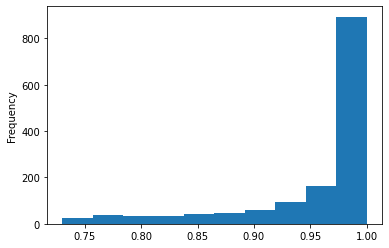

In [7]:
sig_pep_df['score'].plot.hist()
plt.show()
plt.close()

In [8]:
sig_pep_df = sig_pep_df[sig_pep_df['score'].ge(0.95)]
sig_pep_df.shape

(1056, 9)

In [9]:
genes_with_sig_pep = set(sig_pep_df['gene'])

# Testing if gene peripheralness is significantly different across all ontologies for the three datasets

In [10]:
gc_datasets = {
    'MERFISH MOp':'../../outputs/gene_cell/Merfish_MOp_peripheral.csv',
    'Vizgen Brainmap':'../../outputs/gene_cell/Vizgen_Brainmap_peripheral.csv',
    'SeqFISH+ Cortex':'../../outputs/gene_cell/SeqFish_peripheral.csv',
}

gc_df = pd.DataFrame()
for dataset,path in gc_datasets.items():
    dataset_df = pd.read_csv(path)
    dataset_df = dataset_df[
        dataset_df['num_gene_spots'].ge(5)
    ]
    dataset_df['Dataset'] = dataset
    dataset_df['Signal Peptide'] = dataset_df['gene'].isin(genes_with_sig_pep)
    gc_df = pd.concat((gc_df, dataset_df))
    
gc_df.shape

(10006566, 14)

In [11]:
gc_df.groupby('Dataset')['Signal Peptide'].value_counts()

Dataset          Signal Peptide
MERFISH MOp      False             4514002
                 True              1952889
SeqFISH+ Cortex  False               43788
                 True                 4903
Vizgen Brainmap  False             2585582
                 True               905402
Name: Signal Peptide, dtype: int64

In [12]:
gc_df.groupby('Dataset').size()

Dataset
MERFISH MOp        6466891
SeqFISH+ Cortex      48691
Vizgen Brainmap    3490984
dtype: int64

In [13]:
downsampled_gc_df = gc_df.groupby('Dataset').sample(5000)
downsampled_gc_df.groupby('Dataset').size()

Dataset
MERFISH MOp        5000
SeqFISH+ Cortex    5000
Vizgen Brainmap    5000
dtype: int64

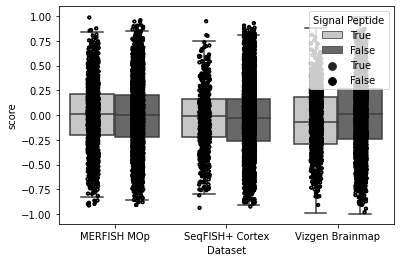

In [14]:
sns.boxplot(
    x = 'Dataset',
    y = 'score',
    hue = 'Signal Peptide',
    hue_order = [True, False],
    palette = 'Greys',
    fliersize = 0,
    data = gc_df,
)

sns.stripplot(
    x = 'Dataset',
    y = 'score',
    hue = 'Signal Peptide',
    hue_order = [True, False],
    dodge = True,
    color = 'black',
    marker="$\circ$",
    linewidth=1,
    data = downsampled_gc_df,
)
plt.show()
plt.close()

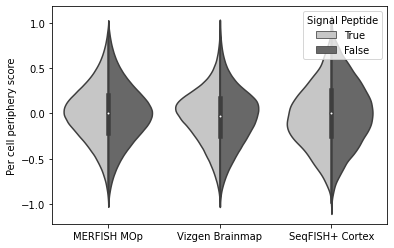

In [15]:
sns.violinplot(
    x = 'Dataset',
    y = 'score',
    hue = 'Signal Peptide',
    hue_order = [True, False],
    split = True,
    palette = 'Greys',
    fliersize = 0,
    data = gc_df,
)
plt.xlabel('')
plt.ylabel('Per cell periphery score')
plt.show()
#plt.savefig('signal_peptide_peripheralness.svg')
plt.close()

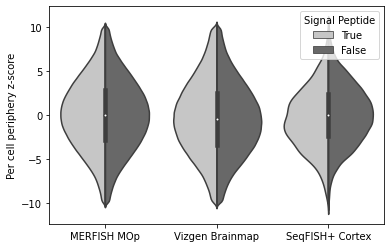

In [16]:
gc_df['z'] = gc_df['score'].div(gc_df['variance'])
no_outlier_gc_df = gc_df[gc_df['z'].between(-10,10)]
sns.violinplot(
    x = 'Dataset',
    y = 'z',
    hue = 'Signal Peptide',
    hue_order = [True, False],
    split = True,
    palette = 'Greys',
    fliersize = 0,
    data = no_outlier_gc_df,
)
plt.xlabel('')
plt.ylabel('Per cell periphery z-score')
plt.show()
plt.close()

In [17]:
ttest_data = {
    'dataset':[],
    'sig_pep_more_central':[],
    'med_periph_with_signal':[],
    'med_periph_without_signal':[],
    'num_genes_with_signal_pep':[],
    'num_genes_without_signal_pep':[],
    'p':[],
    'statistic':[],
}
for dataset,g in gc_df.groupby('Dataset'):
    v1 = g.loc[g['Signal Peptide'],'score'].values
    v2 = g.loc[~g['Signal Peptide'],'score'].values
    s,p = scp.stats.ttest_ind(v1,v2)
    ttest_data['dataset'].append(dataset)
    ttest_data['sig_pep_more_central'].append(np.median(v1) < np.median(v2))
    ttest_data['med_periph_with_signal'].append(np.median(v1))
    ttest_data['med_periph_without_signal'].append(np.median(v2))
    ttest_data['num_genes_with_signal_pep'].append(len(v1))
    ttest_data['num_genes_without_signal_pep'].append(len(v2))
    ttest_data['p'].append(p)
    ttest_data['statistic'].append(s)
    
ttest_df = pd.DataFrame(ttest_data).sort_values('p')
ttest_df

,dataset,sig_pep_more_central,med_periph_with_signal,med_periph_without_signal,num_genes_with_signal_pep,num_genes_without_signal_pep,p,statistic
2,Vizgen Brainmap,False,-0.007481,-0.033457,905402,2585582,0.000000e+00,43.528026
0,MERFISH MOp,False,0.007421,-0.004149,1952889,4514002,2.142244e-278,35.654422
1,SeqFISH+ Cortex,True,-0.065003,0.009159,4903,43788,1.006116e-34,-12.301112


## Testing if median gene/ont peripheralness depends on presence of signal peptide per MOp ontology

In [18]:
mop_df = pd.read_csv('../../outputs/gene_ontology/MOp_peripheral_ReadZs_gene_ontology.csv')
mop_df.head()

,sample_id,gene,ontology,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p
0,m1s1,Acta2,L2/3 IT,397,6.0,611.0,0.087413,26.992258,46.958252,3.938975,0.000082,0.000293
1,m1s1,Acta2,L5 ET,51,6.0,698.0,0.032479,2.767631,6.067670,1.123562,0.261199,0.367769
2,m1s1,Acta2,L5 IT,257,6.0,654.0,0.094270,25.067569,29.188310,4.639891,0.000003,0.000015
3,m1s1,Acta2,L6 CT,26,5.0,304.0,0.176217,4.241585,3.271222,2.345164,0.019019,0.040833
4,m1s1,Acta2,L6 IT,85,6.0,569.0,0.035714,2.599184,10.194193,0.814068,0.415606,0.527449


In [19]:
mop_df['has_sig_pep'] = mop_df['gene'].isin(genes_with_sig_pep)
mop_df.head()

,sample_id,gene,ontology,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p,has_sig_pep
0,m1s1,Acta2,L2/3 IT,397,6.0,611.0,0.087413,26.992258,46.958252,3.938975,0.000082,0.000293,False
1,m1s1,Acta2,L5 ET,51,6.0,698.0,0.032479,2.767631,6.067670,1.123562,0.261199,0.367769,False
2,m1s1,Acta2,L5 IT,257,6.0,654.0,0.094270,25.067569,29.188310,4.639891,0.000003,0.000015,False
3,m1s1,Acta2,L6 CT,26,5.0,304.0,0.176217,4.241585,3.271222,2.345164,0.019019,0.040833,False
4,m1s1,Acta2,L6 IT,85,6.0,569.0,0.035714,2.599184,10.194193,0.814068,0.415606,0.527449,False


In [20]:
mop_df['has_sig_pep'].value_counts()

False    7897
True     3643
Name: has_sig_pep, dtype: int64

In [21]:
mop_df[mop_df['has_sig_pep']]['gene'].value_counts()

Ptprt       175
Igfbp5      165
Shisa9      143
Cdh13       136
Parm1       133
Spon1       128
Sema5a      122
Grin3a      119
Ptprm       117
Cxcl14      116
Ptpru       108
Igfbp4      102
Prss12       98
Olfm3        96
Grm1         95
Timp3        91
Ptprk        91
Npnt         80
Cdh12        80
Pcdh8        75
Flrt3        73
Ramp1        70
Rxfp1        67
C1ql3        67
Ntng2        65
Ccdc3        63
Cntnap5b     61
Nxph1        59
Tmtc2        53
Lypd1        52
Elfn1        51
Sulf1        50
Cbln4        45
Gpc6         44
Egfr         43
Pdgfra       39
Thbs2        37
Alk          37
Sema3e       37
Unc5b        34
Vtn          31
Moxd1        31
Serpinf1     29
Bgn          25
Ccdc80       25
Fst          23
Il1rapl2     22
Pdgfc        21
Mrc1         21
Rspo1        18
Nxph4        16
Rxfp2        16
Egfem1       14
Cd14         12
Tnfaip6      11
Hpse          8
Ror1          2
Chodl         1
Name: gene, dtype: int64

In [23]:
import scipy as scp

ttest_data = {
    'ont':[],
    'sig_pep_more_central':[],
    'med_periph_with_signal':[],
    'med_periph_without_signal':[],
    'num_genes_with_signal_pep':[],
    'num_genes_without_signal_pep':[],
    'p':[],
    'statistic':[],
}
for ont,g in mop_df.groupby('ontology'):
    v1 = g.loc[g['has_sig_pep'],'med_score'].values
    v2 = g.loc[~g['has_sig_pep'],'med_score'].values
    s,p = scp.stats.ttest_ind(v1,v2)
    ttest_data['ont'].append(ont)
    ttest_data['sig_pep_more_central'].append(np.median(v1) < np.median(v2))
    ttest_data['med_periph_with_signal'].append(np.median(v1))
    ttest_data['med_periph_without_signal'].append(np.median(v2))
    ttest_data['num_genes_with_signal_pep'].append(len(v1))
    ttest_data['num_genes_without_signal_pep'].append(len(v2))
    ttest_data['p'].append(p)
    ttest_data['statistic'].append(s)
    
ttest_df = pd.DataFrame(ttest_data).sort_values('p')


#perform BH correction
from statsmodels.stats import multitest

_,adj_p,_,_ = multitest.multipletests(
    ttest_df['p'],
    alpha = 0.05,
    method = 'fdr_bh',
)
ttest_df['bh_p'] = adj_p
ttest_df['significant'] = adj_p <= .05
ttest_df

,ont,sig_pep_more_central,med_periph_with_signal,med_periph_without_signal,num_genes_with_signal_pep,num_genes_without_signal_pep,p,statistic,bh_p,significant
14,SMC,False,0.011496,-0.063407,165,316,0.000009,4.477702,0.000179,True
0,Astro,False,0.065594,-0.004152,119,301,0.000735,3.401529,0.006979,True
10,Lamp5,True,-0.017430,0.008144,156,324,0.011945,-2.523434,0.075649,False
17,VLMC,False,-0.015719,-0.048852,178,292,0.019206,2.349636,0.078537,False
12,Oligo,False,0.028928,0.013873,122,387,0.020668,2.321272,0.078537,False
3,L5 ET,False,0.006742,-0.006370,293,605,0.035149,2.109842,0.111304,False
7,L6 IT,True,0.003681,0.019550,319,778,0.074643,-1.784355,0.202602,False
4,L5 IT,True,-0.014318,0.014333,370,800,0.113458,-1.584027,0.247132,False
13,Pvalb,False,0.000168,0.000000,233,551,0.117063,1.568957,0.247132,False
8,L6 IT Car3,False,0.018706,0.013009,165,304,0.384585,0.870297,0.671945,False


In [24]:
mop_df.shape

(11540, 13)

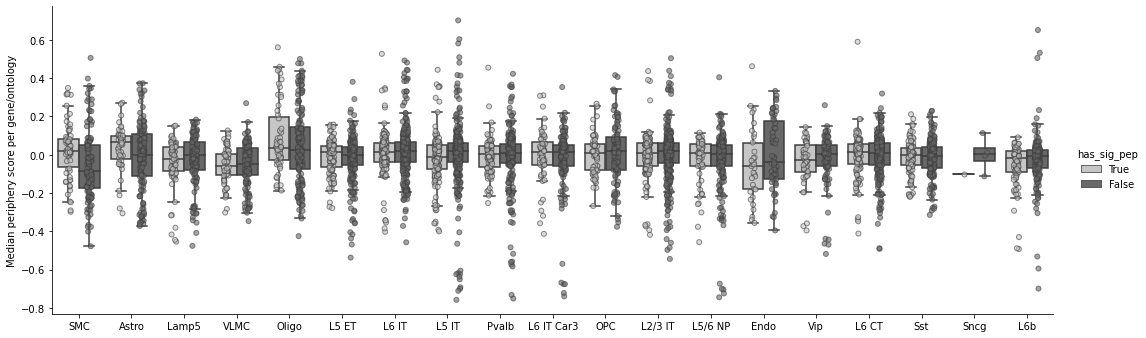

In [25]:
#Tried sorting by increasing score for visualization, but didn't help much
#mop_df['ont_med_score'] = mop_df.groupby('ontology')['med_score'].transform('median')

g = sns.catplot(
    kind = 'box',
    x = 'ontology',
    y = 'med_score',
    order = ttest_df['ont'],
    hue = 'has_sig_pep',
    hue_order = [True,False],
    palette = 'Greys',
    fliersize = 0,
    aspect = 3,
    data = mop_df.sample(5000), #too many spots making figure very large!
)
g.map_dataframe(
    sns.stripplot,
    x = 'ontology',
    y = 'med_score',
    order = ttest_df['ont'],
    hue = 'has_sig_pep',
    hue_order = [True,False],
    palette = 'Greys',
    alpha=0.6,
    linewidth = 1,
    dodge=True,
)
plt.xlabel('')
plt.ylabel('Median periphery score per gene/ontology')
plt.show()
g.savefig('MOp_signal_peptide_peripheralness_by_ontology.svg')
plt.close()

In [32]:
mop_df.head()

,sample_id,gene,ontology,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p,has_sig_pep
0,m1s1,Acta2,L2/3 IT,397,6.0,611.0,0.087413,26.992258,46.958252,3.938975,0.000082,0.000293,False
1,m1s1,Acta2,L5 ET,51,6.0,698.0,0.032479,2.767631,6.067670,1.123562,0.261199,0.367769,False
2,m1s1,Acta2,L5 IT,257,6.0,654.0,0.094270,25.067569,29.188310,4.639891,0.000003,0.000015,False
3,m1s1,Acta2,L6 CT,26,5.0,304.0,0.176217,4.241585,3.271222,2.345164,0.019019,0.040833,False
4,m1s1,Acta2,L6 IT,85,6.0,569.0,0.035714,2.599184,10.194193,0.814068,0.415606,0.527449,False


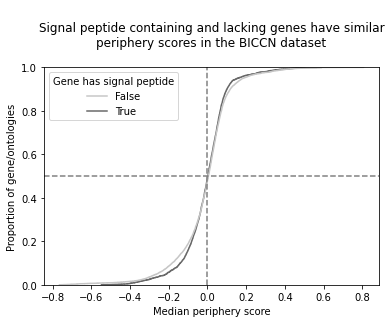

In [36]:
mop_df['Gene has signal peptide'] = mop_df['has_sig_pep']

sns.ecdfplot(
    x = 'med_score',
    hue = 'Gene has signal peptide',
    palette = 'Greys',
    data = mop_df,
)
plt.axhline(0.5, linestyle='dashed', color='grey')
plt.axvline(0.0, linestyle='dashed', color='grey')

plt.title("""
Signal peptide containing and lacking genes have similar
periphery scores in the BICCN dataset
""")
plt.xlabel('Median periphery score')
plt.ylabel('Proportion of gene/ontologies')
plt.show()
plt.close()

## Testing if median gene/ont peripheralness depends on presence of signal peptide per SeqFISH ontology

In [26]:
seq_df = pd.read_csv('../../outputs/gene_ontology/SeqFish_peripheral.csv')
seq_df['has_sig_pep'] = seq_df['gene'].isin(genes_with_sig_pep)
seq_df['has_sig_pep'].value_counts()

False    449
True      58
Name: has_sig_pep, dtype: int64

In [27]:
seq_df.shape

(507, 13)

In [28]:
ttest_data = {
    'ont':[],
    'sig_pep_more_central':[],
    'med_periph_with_signal':[],
    'med_periph_without_signal':[],
    'num_genes_with_signal_pep':[],
    'num_genes_without_signal_pep':[],
    'p':[],
    'statistic':[],
}
for ont,g in seq_df.groupby('annotation'):
    v1 = g.loc[g['has_sig_pep'],'med_score'].values
    v2 = g.loc[~g['has_sig_pep'],'med_score'].values
    
    #Don't test ontologies with too few SRP genes
    if len(v1) < 5:
        continue
    
    s,p = scp.stats.ttest_ind(v1,v2)
    ttest_data['ont'].append(ont)
    ttest_data['sig_pep_more_central'].append(np.median(v1) < np.median(v2))
    ttest_data['med_periph_with_signal'].append(np.median(v1))
    ttest_data['med_periph_without_signal'].append(np.median(v2))
    ttest_data['num_genes_with_signal_pep'].append(len(v1))
    ttest_data['num_genes_without_signal_pep'].append(len(v2))
    ttest_data['p'].append(p)
    ttest_data['statistic'].append(s)
    
ttest_df = pd.DataFrame(ttest_data).sort_values('p')


#perform BH correction
from statsmodels.stats import multitest

_,adj_p,_,_ = multitest.multipletests(
    ttest_df['p'],
    alpha = 0.05,
    method = 'fdr_bh',
)
ttest_df['bh_p'] = adj_p
ttest_df['significant'] = adj_p <= .05
ttest_df

,ont,sig_pep_more_central,med_periph_with_signal,med_periph_without_signal,num_genes_with_signal_pep,num_genes_without_signal_pep,p,statistic,bh_p,significant
2,Excitatory layer 5/6,True,-0.042286,0.034350,19,217,0.003092,-2.989539,0.012369,True
3,choroid plexus,False,0.013215,-0.046668,7,24,0.007183,2.892184,0.014366,True
1,Excitatory layer 3,True,-0.052997,-0.024234,11,99,0.070560,-1.826348,0.094080,False
0,Excitatory 5/6,True,0.014672,0.040281,8,52,0.257838,-1.142749,0.257838,False


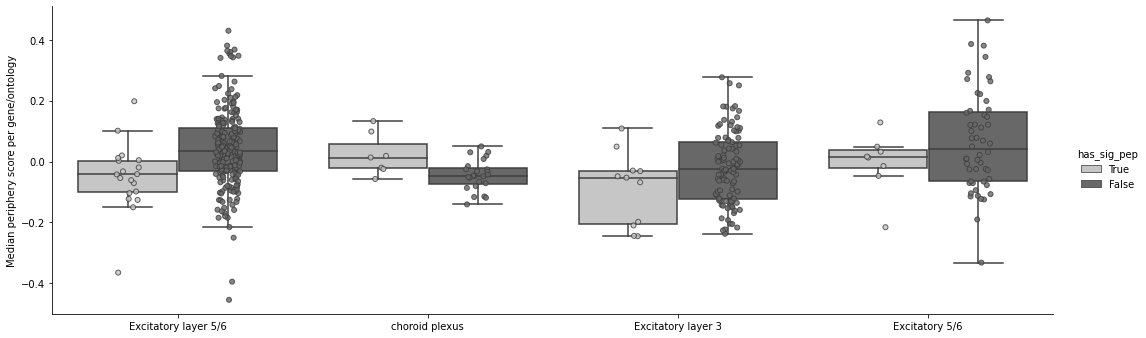

In [29]:
#Tried sorting by increasing score for visualization, but didn't help much
#mop_df['ont_med_score'] = mop_df.groupby('ontology')['med_score'].transform('median')

g = sns.catplot(
    kind = 'box',
    x = 'annotation',
    y = 'med_score',
    order = ttest_df['ont'],
    hue = 'has_sig_pep',
    hue_order = [True,False],
    palette = 'Greys',
    fliersize = 0,
    aspect = 3,
    data = seq_df,
)
g.map_dataframe(
    sns.stripplot,
    x = 'annotation',
    y = 'med_score',
    order = ttest_df['ont'],
    hue = 'has_sig_pep',
    hue_order = [True,False],
    palette = 'Greys',
    alpha=0.8,
    linewidth = 1,
    dodge=True,
)
plt.xlabel('')
plt.ylabel('Median periphery score per gene/ontology')
plt.show()
g.savefig('Seq_signal_peptide_peripheralness_by_ontology.svg')
plt.close()